In [65]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.api import OLS
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

pd.set_option('mode.chained_assignment', None)

In [2]:
def query_ticker_data():
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_by_month`
        ORDER BY date
    """
    
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df


def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [3]:
all = query_ticker_data()

In [4]:
apple = all[all['ticker'] == 'AAPL']
netflix = all[all['ticker'] == 'NFLX']
microsoft = all[all['ticker'] == 'MSFT']
amazon = all[all['ticker'] == 'AMZN']
alphabet = all[all['ticker'] == 'GOOGL']
coke = all[all['ticker'] == 'KO']

In [5]:
apple.name = "Apple"
netflix.name = "Netflix"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [74]:
TARGET_DF = amazon

In [75]:
TARGET_DF['lag_1'] = TARGET_DF['volume_weighted_average_price'].shift(1)
TARGET_DF['lag_1_volume'] = TARGET_DF['volume'].shift(1)
TARGET_DF['lag_1_volume'] = np.log(TARGET_DF['lag_1_volume'])

In [76]:
X = TARGET_DF[['lag_1', 'lag_1_volume']]
X.dropna(inplace=True)  # drop missing values in the feature set
X = sm.add_constant(X)
y = TARGET_DF.loc[:, 'volume_weighted_average_price']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target
model = OLS(y,X)
fitted = model.fit()
y_pred = pd.Series(fitted.predict(X), index=X.index)

In [77]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     volume_weighted_average_price   R-squared:                       0.907
Model:                                       OLS   Adj. R-squared:                  0.903
Method:                            Least Squares   F-statistic:                     277.0
Date:                           Mon, 23 Oct 2023   Prob (F-statistic):           4.36e-30
Time:                                   04:44:20   Log-Likelihood:                -221.60
No. Observations:                             60   AIC:                             449.2
Df Residuals:                                 57   BIC:                             455.5
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -27.1753     89.254     -0.304      0.762    -205.903     151.552
lag_1            0.9453      0.042     22.639      0.000       0.862       1.029
lag_1_volume     1.9107      4.822      0.396      0.693      -7.744      11.566
==============================================================================
Omnibus:                       15.076   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.046
Skew:                          -0.796   Prob(JB):                     2.21e-06
Kurtosis:                       5.808   Cond. No.                     9.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='lag_1', ylabel='volume_weighted_average_price'>

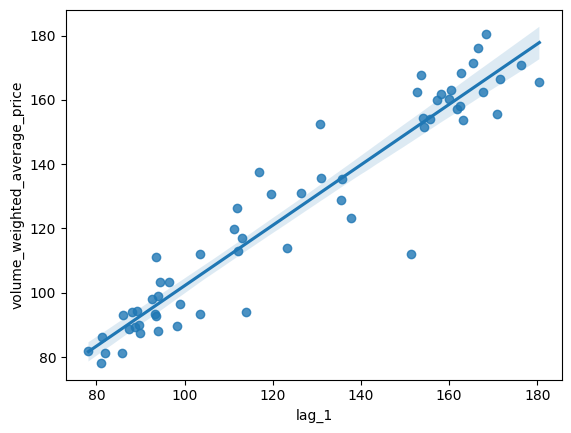

In [78]:
sns.regplot(x='lag_1', y='volume_weighted_average_price', data=TARGET_DF)